In [ ]:
!pip install tqdm

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), # degree: 회전, translate: 이동, scale: 줌
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

num_train = len(full_train_set)  # 50000
val_size = 10000
train_size = num_train - val_size

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)
val_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_val)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 44.2MB/s]


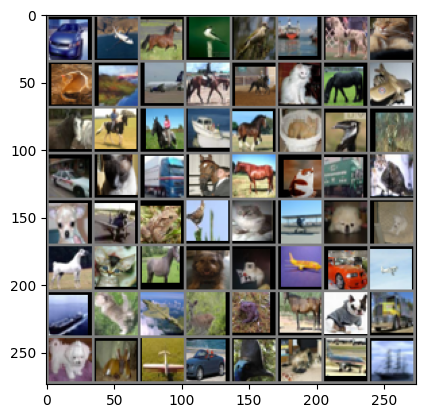

car   plane horse bird  bird  ship  dog   cat   cat   plane plane horse horse cat   horse plane horse horse horse ship  horse cat   bird  deer  car   cat   truck horse horse cat   truck cat   dog   plane frog  bird  cat   plane dog   dog   horse cat   horse dog   dog   plane car   plane ship  cat   plane deer  frog  horse dog   truck dog   deer  plane car   bird  cat   plane ship 


In [ ]:
def imshow(img):
  img = img / 2 + 0.5 # unnormarlize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same')
    self.bn1_1 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
    self.bn1_2 = nn.BatchNorm2d(32)

    self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
    self.bn2_1 = nn.BatchNorm2d(64)
    self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same')
    self.bn2_2 = nn.BatchNorm2d(64)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
    self.bn3 = nn.BatchNorm2d(128)

    self.fc1 = nn.Linear(128 * 4 * 4, 256)
    self.bn_fc1 = nn.BatchNorm1d(256)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = F.relu(self.bn1_1(self.conv1_1(x)))
    x = self.pool(F.relu(self.bn1_2(self.conv1_2(x))))
    x = F.relu(self.bn2_1(self.conv2_1(x)))
    x = self.pool(F.relu(self.bn2_2(self.conv2_2(x))))
    x = F.relu(self.bn3(self.conv3(x)))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.bn_fc1(self.fc1(x)))
    x = self.dropout(x)
    x = self.fc2(x) # logits
    return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

num_epochs = 20

for epoch in range(num_epochs):
    net.train() # 학습 모드
    train_loss_sum = 0.0
    train_correct = 0
    train_total = 0

    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}/{num_epochs} (train)")
    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        train_loss_sum += loss.item() * bs
        _, preds = outputs.max(1)
        train_correct += (preds == labels).sum().item()
        train_total += bs

        curr_loss = train_loss_sum / train_total
        curr_acc = train_correct / train_total * 100
        pbar.set_postfix(train_loss=f"{curr_loss:.4f}", train_acc=f"{curr_acc:.2f}%")

    train_loss = train_loss_sum / train_total
    train_acc = train_correct / train_total * 100


    net.eval() # 검증 모드
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        pbar_val = tqdm(enumerate(valloader), total=len(valloader), desc=f"Epoch {epoch+1}/{num_epochs} (val)   ")
        for i, (inputs, labels) in pbar_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            bs = labels.size(0)
            val_loss_sum += loss.item() * bs
            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += bs

            curr_vloss = val_loss_sum / val_total
            curr_vacc = val_correct / val_total * 100
            pbar_val.set_postfix(val_loss=f"{curr_vloss:.4f}", val_acc=f"{curr_vacc:.2f}%")

    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total * 100


    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | "
          f"val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")

print("Finished Training")


Epoch 1/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 1/20] train_loss: 1.4738 | train_acc: 46.96% | val_loss: 1.1786 | val_acc: 57.79%


Epoch 2/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 2/20] train_loss: 1.1554 | train_acc: 58.99% | val_loss: 0.9751 | val_acc: 65.83%


Epoch 3/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 3/20] train_loss: 1.0254 | train_acc: 64.17% | val_loss: 0.8417 | val_acc: 70.36%


Epoch 4/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 4/20] train_loss: 0.9343 | train_acc: 67.40% | val_loss: 0.7454 | val_acc: 73.60%


Epoch 5/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 5/20] train_loss: 0.8666 | train_acc: 69.77% | val_loss: 0.6775 | val_acc: 76.38%


Epoch 6/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 6/20] train_loss: 0.8129 | train_acc: 71.81% | val_loss: 0.6442 | val_acc: 77.56%


Epoch 7/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 7/20] train_loss: 0.7801 | train_acc: 72.70% | val_loss: 0.6071 | val_acc: 78.72%


Epoch 8/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 8/20] train_loss: 0.7417 | train_acc: 74.00% | val_loss: 0.5803 | val_acc: 79.39%


Epoch 9/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 9/20] train_loss: 0.7149 | train_acc: 75.02% | val_loss: 0.5532 | val_acc: 80.55%


Epoch 10/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 10/20] train_loss: 0.6924 | train_acc: 75.79% | val_loss: 0.5670 | val_acc: 79.95%


Epoch 11/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 11/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 11/20] train_loss: 0.6742 | train_acc: 76.68% | val_loss: 0.5082 | val_acc: 82.62%


Epoch 12/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 12/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 12/20] train_loss: 0.6508 | train_acc: 77.49% | val_loss: 0.4924 | val_acc: 83.01%


Epoch 13/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 13/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 13/20] train_loss: 0.6351 | train_acc: 78.04% | val_loss: 0.4739 | val_acc: 83.55%


Epoch 14/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 14/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 14/20] train_loss: 0.6184 | train_acc: 78.70% | val_loss: 0.4519 | val_acc: 84.29%


Epoch 15/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 15/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 15/20] train_loss: 0.5986 | train_acc: 79.21% | val_loss: 0.4621 | val_acc: 84.03%


Epoch 16/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 16/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 16/20] train_loss: 0.5909 | train_acc: 79.59% | val_loss: 0.4554 | val_acc: 84.26%


Epoch 17/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 17/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 17/20] train_loss: 0.5771 | train_acc: 80.02% | val_loss: 0.4166 | val_acc: 85.49%


Epoch 18/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 18/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 18/20] train_loss: 0.5648 | train_acc: 80.60% | val_loss: 0.4127 | val_acc: 85.83%


Epoch 19/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 19/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 19/20] train_loss: 0.5574 | train_acc: 80.81% | val_loss: 0.4095 | val_acc: 85.69%


Epoch 20/20 (train):   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 20/20 (val)   :   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 20/20] train_loss: 0.5506 | train_acc: 80.81% | val_loss: 0.3958 | val_acc: 86.25%
Finished Training


In [ ]:
net.eval()  # 평가 모드
test_loss_sum = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():  # 기울기 계산 비활성화
    pbar_test = tqdm(enumerate(testloader), total=len(testloader), desc="Test")
    for i, (inputs, labels) in pbar_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        bs = labels.size(0)
        test_loss_sum += loss.item() * bs
        _, preds = outputs.max(1)
        test_correct += (preds == labels).sum().item()
        test_total += bs

        pbar_test.set_postfix(
            test_loss=f"{test_loss_sum/test_total:.4f}",
            test_acc=f"{100*test_correct/test_total:.2f}%"
        )

test_loss = test_loss_sum / test_total
test_acc  = 100 * test_correct / test_total
print(f"[Test] loss: {test_loss:.4f} | acc: {test_acc:.2f}%")

Test:   0%|          | 0/157 [00:00<?, ?it/s]

[Test] loss: 0.4832 | acc: 83.03%
